# Introduction
In this notebook, we explore two different recommendation algorithms, namely Inductive Logic Programming (ILP) and the Apriori algorithm, using a transactional dataset. The objective is to compare these two methods in terms of their ability to generate accurate product recommendations. The ILP method uses learned rules to recommend products, while the Apriori algorithm generates association rules based on the frequency of itemsets.

# 1. Data Understanding and Cleaning

## 1.1. Install all the Libraries

In [7]:
pip install --upgrade "dask[dataframe]"

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.2/242.2 KB 3.0 MB/s eta 0:00:007.7 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 2.1 MB/s eta 0:00:000m eta 0:00:010:00:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
!pip install --upgrade pandas

Defaulting to user installation because normal site-packages is not writeable


## 1.2. Load all the Datasets

In [1]:
import dask.dataframe as dd

# Load datasets using Dask
orders = dd.read_csv('orders.csv')
order_products_prior = dd.read_csv('order_products__prior.csv')
products = dd.read_csv('products.csv')
aisles = dd.read_csv('aisles.csv')
departments = dd.read_csv('departments.csv')

# Display the first 5 rows of each DataFrame
print("Orders DataFrame:")
print(orders.head())

print("\nOrder Products Prior DataFrame:")
print(order_products_prior.head())

print("\nProducts DataFrame:")
print(products.head())

print("\nAisles DataFrame:")
print(aisles.head())

print("\nDepartments DataFrame:")
print(departments.head())

Orders DataFrame:
   order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4          4                  7   
4    431534        1    prior             5          4                 15   

   days_since_prior_order  
0                     NaN  
1                    15.0  
2                    21.0  
3                    29.0  
4                    28.0  

Order Products Prior DataFrame:
   order_id  product_id  add_to_cart_order  reordered
0         2       33120                  1          1
1         2       28985                  2          1
2         2        9327                  3          0
3         2       45918                  4          1
4         2       30035                  5      

## 1.3. Merge all the datasets into one

In [2]:
# Merge datasets
order_products = dd.merge(order_products_prior, orders, on='order_id', how='left')
order_products = dd.merge(order_products, products, on='product_id', how='left')
order_products = dd.merge(order_products, aisles, on='aisle_id', how='left')
order_products = dd.merge(order_products, departments, on='department_id', how='left')

# Convert to Pandas DataFrame for operations that Dask doesn't support
order_products = order_products.compute()

print(order_products.head())

   order_id  product_id  add_to_cart_order  reordered  user_id eval_set  \
0         2       33120                  1          1   202279    prior   
1         2       28985                  2          1   202279    prior   
2         2        9327                  3          0   202279    prior   
3         2       45918                  4          1   202279    prior   
4         2       30035                  5          0   202279    prior   

   order_number  order_dow  order_hour_of_day  days_since_prior_order  \
0             3          5                  9                     8.0   
1             3          5                  9                     8.0   
2             3          5                  9                     8.0   
3             3          5                  9                     8.0   
4             3          5                  9                     8.0   

            product_name  aisle_id  department_id               aisle  \
0     Organic Egg Whites        86   

# Dataset Description
The dataset consists of transactional data, where each record represents a purchase made by a user. The main features include `order_id`, `user_id`, `product_id`, and `product_name`. This data will be used to build and compare two recommendation systems: one based on ILP and the other on Apriori.

## 1.4. Check for Missing Values

In [3]:
print("Missing values in each column:")
print(order_products.isnull().sum())

Missing values in each column:
order_id                        0
product_id                      0
add_to_cart_order               0
reordered                       0
user_id                         0
eval_set                        0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order    2078068
product_name                    0
aisle_id                        0
department_id                   0
aisle                           0
department                      0
dtype: int64


## 1.5. The column 'days_since_prior_order' has missing values. We will fill these missing values with the median value of the column.

In [4]:
# Fill missing values in 'days_since_prior_order' with the median value
order_products['days_since_prior_order'].fillna(order_products['days_since_prior_order'].median(), inplace=True)

# Verify that there are no missing values left
print(order_products.isnull().sum())

order_id                  0
product_id                0
add_to_cart_order         0
reordered                 0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
product_name              0
aisle_id                  0
department_id             0
aisle                     0
department                0
dtype: int64


## 1.6. Convert Data Types: Ensure that the data types of the columns are appropriate for analysis.

In [5]:
order_products['order_id'] = order_products['order_id'].astype('int')
order_products['product_id'] = order_products['product_id'].astype('int')
order_products['add_to_cart_order'] = order_products['add_to_cart_order'].astype('int')
order_products['reordered'] = order_products['reordered'].astype('int')
order_products['user_id'] = order_products['user_id'].astype('int')
order_products['order_number'] = order_products['order_number'].astype('int')
order_products['order_dow'] = order_products['order_dow'].astype('int')
order_products['order_hour_of_day'] = order_products['order_hour_of_day'].astype('int')
order_products['days_since_prior_order'] = order_products['days_since_prior_order'].astype('float')

# 2. Exploratory Data Analysis (EDA)

## 2.1. Descriptive Statistics

In [6]:
print("Descriptive statistics:")
print(order_products.describe())

Descriptive statistics:
           order_id    product_id  add_to_cart_order     reordered  \
count  3.243449e+07  3.243449e+07       3.243449e+07  3.243449e+07   
mean   1.710749e+06  2.557634e+04       8.351076e+00  5.896975e-01   
std    9.873007e+05  1.409669e+04       7.126671e+00  4.918886e-01   
min    2.000000e+00  1.000000e+00       1.000000e+00  0.000000e+00   
25%    8.559430e+05  1.353000e+04       3.000000e+00  0.000000e+00   
50%    1.711048e+06  2.525600e+04       6.000000e+00  1.000000e+00   
75%    2.565514e+06  3.793500e+04       1.100000e+01  1.000000e+00   
max    3.421083e+06  4.968800e+04       1.450000e+02  1.000000e+00   

            user_id  order_number     order_dow  order_hour_of_day  \
count  3.243449e+07  3.243449e+07  3.243449e+07       3.243449e+07   
mean   1.029372e+05  1.714205e+01  2.738818e+00       1.342498e+01   
std    5.946648e+04  1.753504e+01  2.090049e+00       4.246365e+00   
min    1.000000e+00  1.000000e+00  0.000000e+00       0.000000e+0

## 2.2. Distribution of Orders by Day of the Week

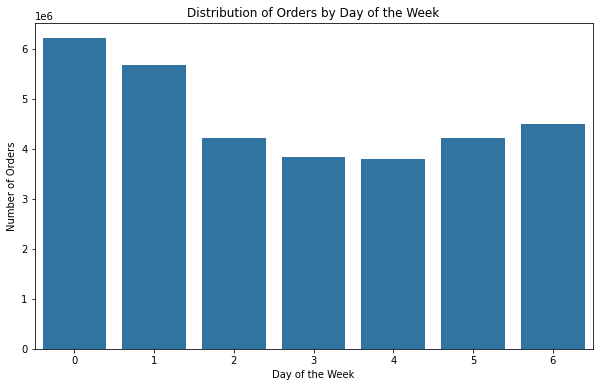

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(data=order_products, x='order_dow')
plt.title('Distribution of Orders by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Orders')
plt.show()

## 2.3. Distribution of Orders by Hour of the Day

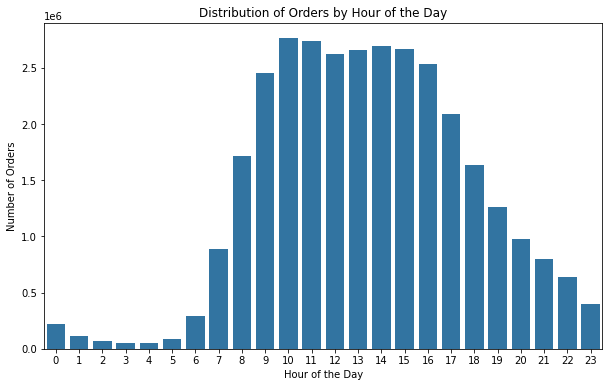

In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(data=order_products, x='order_hour_of_day')
plt.title('Distribution of Orders by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Orders')
plt.show()

## 2.4 Top 10 Most Ordered Products

/tmp/ipykernel_1126506/61477036.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products.values, y=top_products.index, palette='viridis')


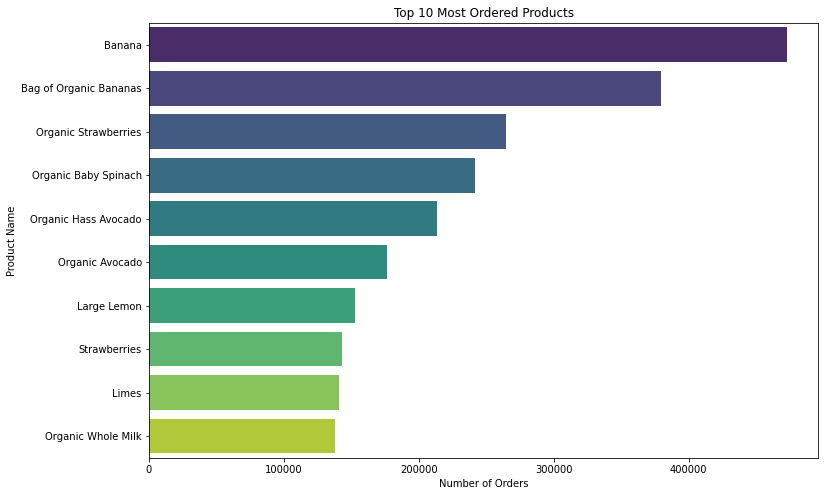

In [9]:
top_products = order_products['product_name'].value_counts().head(10)
plt.figure(figsize=(12, 8))
sns.barplot(x=top_products.values, y=top_products.index, palette='viridis')
plt.title('Top 10 Most Ordered Products')
plt.xlabel('Number of Orders')
plt.ylabel('Product Name')
plt.show()

## 2.5. Top 10 Products by Reorder Rate

Reorder Rate: 0.59


/tmp/ipykernel_1126506/4172875347.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=reorder_rate_by_product.values, y=reorder_rate_by_product.index, palette='coolwarm')


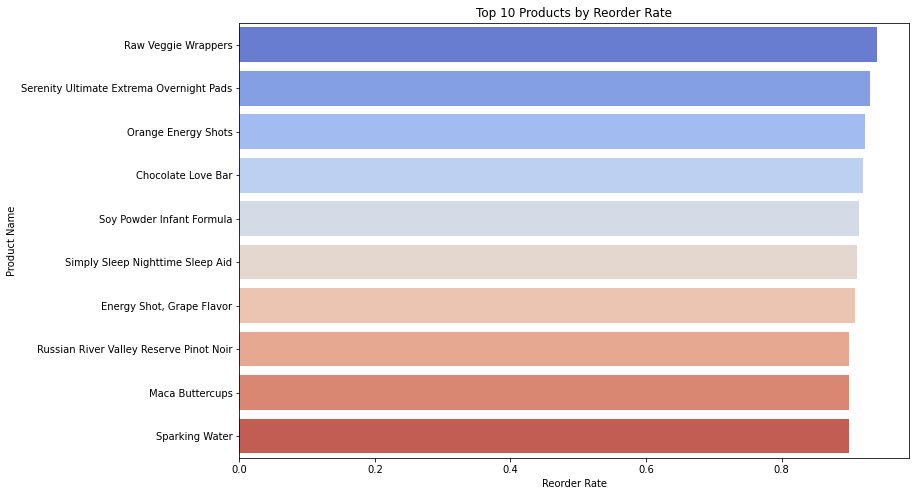

In [10]:
reorder_rate = order_products['reordered'].mean()
print(f"Reorder Rate: {reorder_rate:.2f}")

reorder_rate_by_product = order_products.groupby('product_name')['reordered'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 8))
sns.barplot(x=reorder_rate_by_product.values, y=reorder_rate_by_product.index, palette='coolwarm')
plt.title('Top 10 Products by Reorder Rate')
plt.xlabel('Reorder Rate')
plt.ylabel('Product Name')
plt.show()

# 2.6. Heatmap

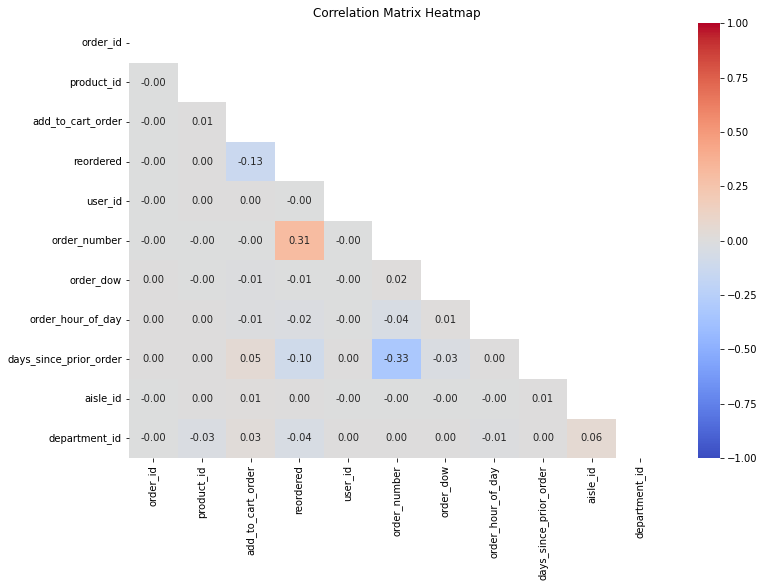

In [11]:
import numpy as np

# Select only the numeric columns for correlation calculation
numeric_columns = order_products.select_dtypes(include=[np.number])

# Calculate the correlation matrix
corr = numeric_columns.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Draw the heatmap
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()

# 2.7. Box Plot: Distribution of Orders by Hour of the Day

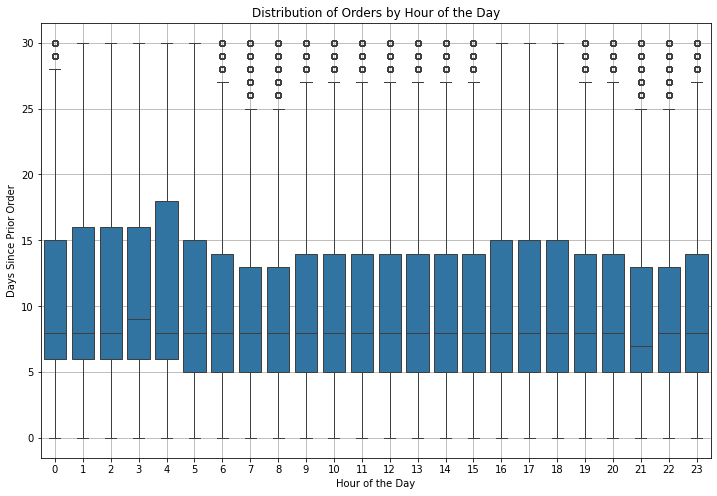

In [12]:
# Plot the distribution of orders by hour of the day
plt.figure(figsize=(12, 8))
sns.boxplot(x='order_hour_of_day', y='days_since_prior_order', data=order_products)
plt.title('Distribution of Orders by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Days Since Prior Order')
plt.grid(True)
plt.show()

## 2.8. Pairplot of Order Timing Features

C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


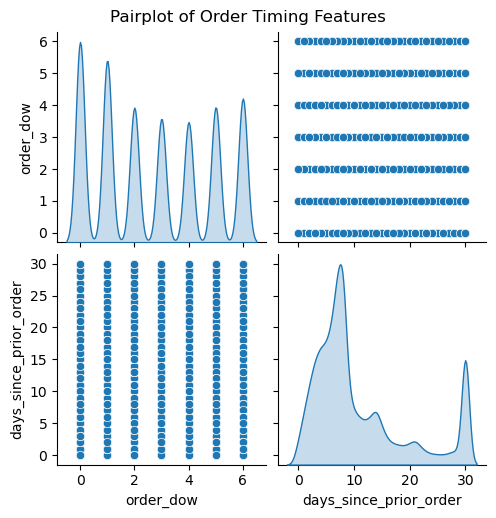

In [7]:
# Selecting relevant columns for the pairplot
timing_columns = order_products[['order_dow', 'order_hour_of_day', 'days_since_prior_order']]

# Selecting only two columns to simplify the pairplot
timing_columns_sample = timing_columns[['order_dow', 'days_since_prior_order']].sample(frac=0.01, random_state=42)

# Pairplot
sns.pairplot(timing_columns_sample, diag_kind='kde')
plt.suptitle('Pairplot of Order Timing Features', y=1.02)
plt.show()

## 2.9. Feature Importance using Random Forest

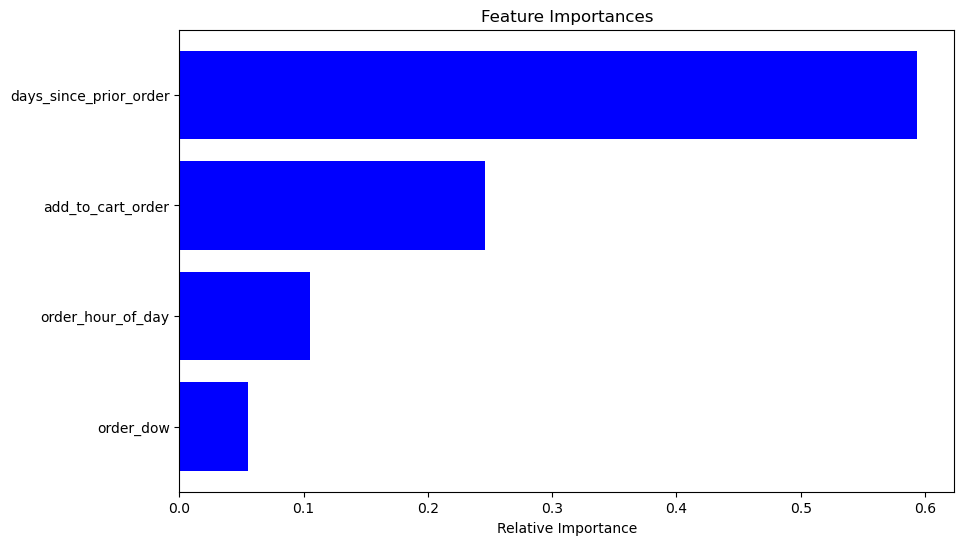

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Prepare the data
X = order_products[['order_dow', 'order_hour_of_day', 'days_since_prior_order', 'add_to_cart_order']]
y = order_products['reordered']

# Reduce the dataset size by sampling 5% of the entire data
# Sample indices first to ensure consistency
sample_indices = X.sample(frac=0.05, random_state=42).index

# Apply the same indices to both X and y
X_sample = X.loc[sample_indices].reset_index(drop=True)
y_sample = y.loc[sample_indices].reset_index(drop=True)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

# Train the Random Forest model on the sampled data
model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# Calculate feature importances
importances = model.feature_importances_
features = X.columns
indices = np.argsort(importances)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## 2.10. Customer Segmentation Analysis

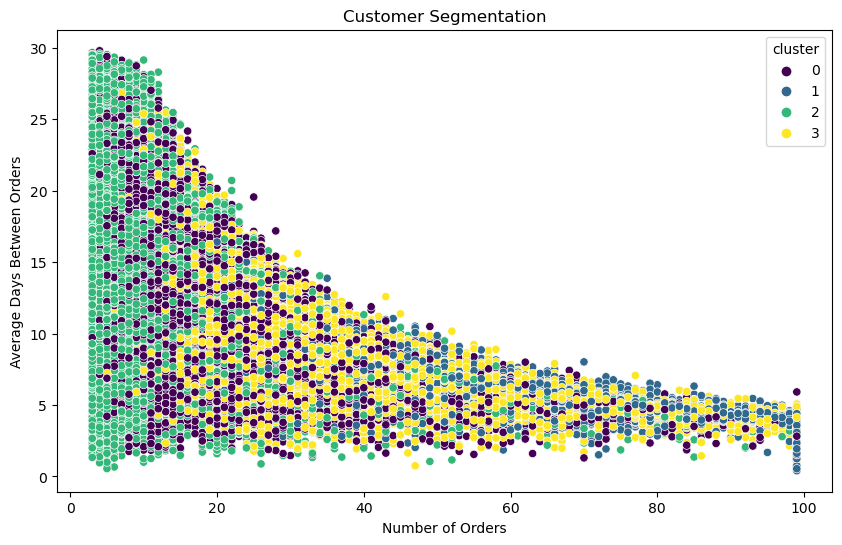

In [12]:
from sklearn.cluster import KMeans

# Example features for segmentation
segmentation_features = order_products.groupby('user_id').agg({
    'order_id': 'nunique',  # Number of orders
    'days_since_prior_order': 'mean',  # Average days between orders
    'product_id': 'nunique'  # Number of unique products purchased
}).reset_index()

# Fit KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
segmentation_features['cluster'] = kmeans.fit_predict(segmentation_features[['order_id', 'days_since_prior_order', 'product_id']])

# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='order_id', y='days_since_prior_order', hue='cluster', data=segmentation_features, palette='viridis')
plt.title('Customer Segmentation')
plt.xlabel('Number of Orders')
plt.ylabel('Average Days Between Orders')
plt.show()

## 2.11. 3D Visualization of Customer Segmentation Based on Purchasing Behaviour Using K-Means Clustering

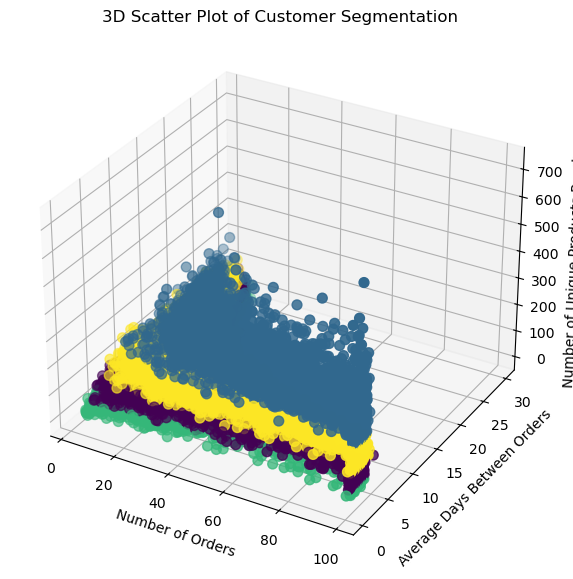

In [8]:
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

# Example features for segmentation
segmentation_features = order_products.groupby('user_id').agg({
    'order_id': 'nunique',  # Number of orders
    'days_since_prior_order': 'mean',  # Average days between orders
    'product_id': 'nunique'  # Number of unique products purchased
}).reset_index()

# Fit KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
segmentation_features['cluster'] = kmeans.fit_predict(segmentation_features[['order_id', 'days_since_prior_order', 'product_id']])

# 3D Scatter plot of the clusters
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(segmentation_features['order_id'], segmentation_features['days_since_prior_order'], segmentation_features['product_id'], c=segmentation_features['cluster'], cmap='viridis', s=50)

# Labels and title
ax.set_xlabel('Number of Orders')
ax.set_ylabel('Average Days Between Orders')
ax.set_zlabel('Number of Unique Products Purchased')
plt.title('3D Scatter Plot of Customer Segmentation')
plt.show()

## 2.12. Pairwise Density Plot (Hexbin Plot)

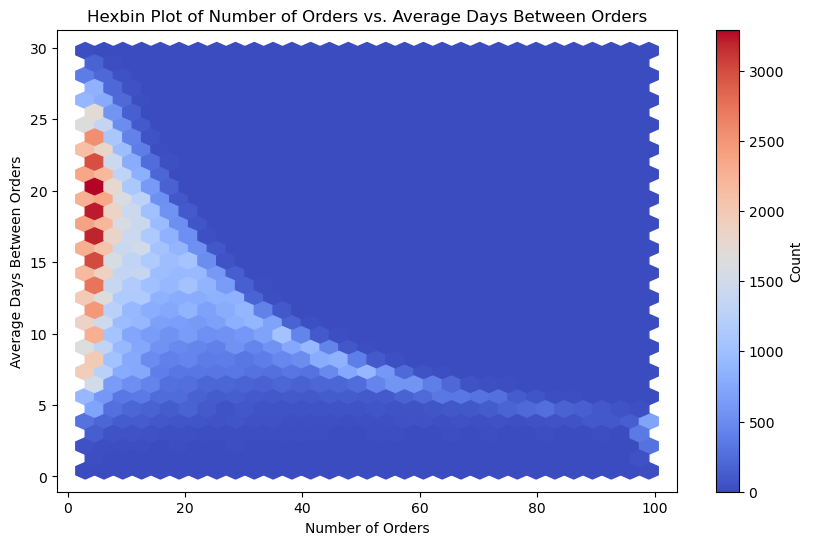

In [9]:
plt.figure(figsize=(10, 6))
plt.hexbin(segmentation_features['order_id'], segmentation_features['days_since_prior_order'], gridsize=30, cmap='coolwarm')
plt.colorbar(label='Count')
plt.title('Hexbin Plot of Number of Orders vs. Average Days Between Orders')
plt.xlabel('Number of Orders')
plt.ylabel('Average Days Between Orders')
plt.show()

## 2.13. Radar Chart of Key Customer Metrics for Cluster 0 in E-Commerce Segmentation

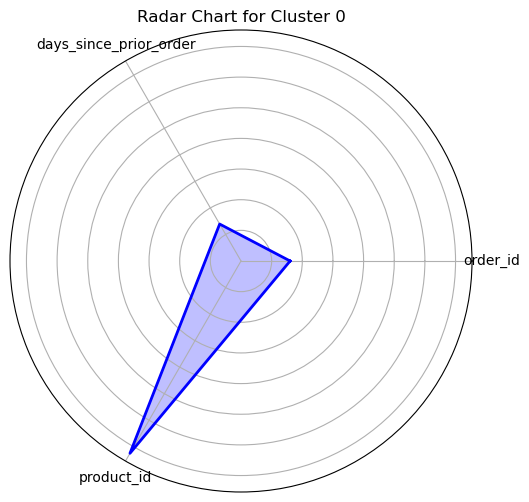

In [10]:
# Choose one cluster for illustration
cluster_0 = segmentation_features[segmentation_features['cluster'] == 0].mean()

# Define labels and number of variables
labels = ['order_id', 'days_since_prior_order', 'product_id']
num_vars = len(labels)

# Compute angle for each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Repeat the first value to close the plot
values = cluster_0[labels].values.flatten().tolist()
values += values[:1]
angles += angles[:1]

# Plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.fill(angles, values, color='blue', alpha=0.25)
ax.plot(angles, values, color='blue', linewidth=2)
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)

plt.title('Radar Chart for Cluster 0')
plt.show()

## 2.14. Contour Plot of Customer Order Frequency vs. Reorder Timing

C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


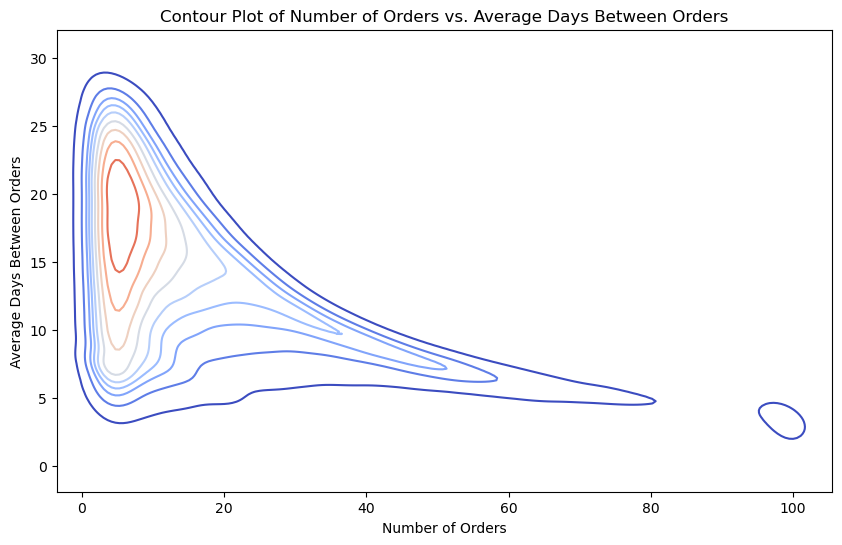

In [12]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=segmentation_features, x='order_id', y='days_since_prior_order', levels=10, cmap='coolwarm')
plt.title('Contour Plot of Number of Orders vs. Average Days Between Orders')
plt.xlabel('Number of Orders')
plt.ylabel('Average Days Between Orders')
plt.show()

# 3. Pre-processing the data for Modelling

## 3.1. Subsampling the data

In [7]:
# Select a chunk of the data (150,000 rows)
data_chunk = order_products.sample(n=150000, random_state=1)

## 3.2. Add Time-based features for better recommendations

In [8]:
# Add order_time for illustration purposes if not present
# Let's assume the first order date is '2021-01-01'
start_date = pd.to_datetime('2021-01-01')

# Create a function to generate synthetic dates
def generate_order_time(row):
    days_offset = (row['order_number'] - 1) * 7 + row['order_dow']  # order_dow is already the day of the week
    return start_date + pd.to_timedelta(days_offset, unit='d') + pd.to_timedelta(row['order_hour_of_day'], unit='h')

data_chunk['order_time'] = data_chunk.apply(generate_order_time, axis=1)

print(data_chunk[['order_time', 'order_dow', 'order_hour_of_day', 'order_number']].head())

                 order_time  order_dow  order_hour_of_day  order_number
2599147 2021-06-25 09:00:00          0                  9            26
1262509 2021-03-10 09:00:00          5                  9            10
393128  2021-08-17 09:00:00          4                  9            33
1445936 2021-05-25 10:00:00          4                 10            21
3120253 2021-02-04 12:00:00          6                 12             5


## 3.3. Extract time based features

In [9]:
# Extract day of the week, hour of the day, and month from 'order_time'
data_chunk['order_day_of_week'] = data_chunk['order_time'].dt.dayofweek
data_chunk['order_hour'] = data_chunk['order_time'].dt.hour
data_chunk['order_month'] = data_chunk['order_time'].dt.month

print(data_chunk[['order_time', 'order_day_of_week', 'order_hour', 'order_month']].head())

                 order_time  order_day_of_week  order_hour  order_month
2599147 2021-06-25 09:00:00                  4           9            6
1262509 2021-03-10 09:00:00                  2           9            3
393128  2021-08-17 09:00:00                  1           9            8
1445936 2021-05-25 10:00:00                  1          10            5
3120253 2021-02-04 12:00:00                  3          12            2


## 3.4. Add Occasion based features

In [10]:
# Define a function to add occasion-based features
def add_occasion(row):
    if row['order_month'] == 12:
        return 'Christmas'
    elif row['order_month'] == 11 and row['order_day_of_week'] in [3, 4]:
        return 'Thanksgiving'
    elif row['order_month'] == 2 and row['order_day_of_week'] == 13:
        return 'Valentine\'s Day'
    else:
        return 'None'

# Apply the function to create a new column
data_chunk['occasion'] = data_chunk.apply(add_occasion, axis=1)

print(data_chunk[['order_time', 'order_day_of_week', 'order_hour', 'order_month', 'occasion']].head())

                 order_time  order_day_of_week  order_hour  order_month  \
2599147 2021-06-25 09:00:00                  4           9            6   
1262509 2021-03-10 09:00:00                  2           9            3   
393128  2021-08-17 09:00:00                  1           9            8   
1445936 2021-05-25 10:00:00                  1          10            5   
3120253 2021-02-04 12:00:00                  3          12            2   

        occasion  
2599147     None  
1262509     None  
393128      None  
1445936     None  
3120253     None  


## 3.5. We'll use StandardScaler from scikit-learn to scale the numerical features.

In [11]:
from sklearn.preprocessing import StandardScaler

# Define the numerical columns to scale, including the new time-based features
numerical_cols = ['add_to_cart_order', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'order_day_of_week', 'order_hour', 'order_month']

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the data
data_chunk[numerical_cols] = scaler.fit_transform(data_chunk[numerical_cols])

print("Scaled DataFrame with Time-Based Features:")
print(data_chunk[numerical_cols].head())

Scaled DataFrame with Time-Based Features:
         add_to_cart_order  order_number  order_dow  order_hour_of_day  \
2599147           2.051445      0.501990  -1.308142          -1.042927   
1262509           0.369495     -0.408817   1.089907          -1.042927   
393128           -0.751806      0.900468   0.610297          -1.042927   
1445936           2.191608      0.217363   0.610297          -0.806995   
3120253           0.089170     -0.693444   1.569516          -0.335132   

         days_since_prior_order  order_day_of_week  order_hour  order_month  
2599147               -0.690954           0.408256   -1.042927     0.796817  
1262509               -0.104378          -0.633134   -1.042927    -0.251679  
393128                -0.925585          -1.153828   -1.042927     1.495814  
1445936                0.364883          -1.153828   -0.806995     0.447318  
3120253                0.599514          -0.112439   -0.335132    -0.601177  


# 4. Relational Machine Leaning with Inductive Logic Programming using PyGol

# ILP-Based Recommendations
Inductive Logic Programming (ILP) is a form of machine learning that generates hypotheses or rules from observations. In this context, ILP will be used to generate rules based on user transactions, which will then be applied to recommend products to users. The learned rules will be stored in the `learned_hypothesis` file and applied to each user’s data to generate recommendations


In [12]:
!pip install graphviz

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 KB 1.0 MB/s eta 0:00:008.9 MB/s eta 0:00:01


In [14]:
!pip install janus_swi

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 KB 1.8 MB/s eta 0:00:004.1 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for janus_swi: filename=janus_swi-1.4.0-cp310-cp310-linux_x86_64.whl size=125410 sha256=59c19034d6d5586c5e1cf389dadae74608e56dc42aa7f51b8a605a65e24c8d9d
  Stored in directory: /user/HS401/vi00085/.cache/pip/wheels/fa/af/78/cb80c16a52f52dc1bc90cddaf0e2597cddce5b1a6aab6117bf
Successfully built janus_swi


## 4.1. Preparing the data for modelling with Pygol

In [12]:
import sys
import numpy as np
from PyGol import *

# Insert the PyGol path
sys.path.insert(0, '../../')

# Assuming data_chunk is your preprocessed DataFrame
feature_cols = ['user_id', 'product_id', 'order_day_of_week', 'order_hour', 'order_month', 'occasion']
target = 'likes'  # This should be a meaningful binary target based on actual data

# Example of creating the 'likes' column (adjust logic as necessary)
data_chunk['likes'] = data_chunk.groupby(['user_id', 'product_id'])['order_id'].transform('count') > 2
data_chunk['likes'] = data_chunk['likes'].astype(int)  # Convert to binary (0 or 1)

# Convert necessary columns to strings for compatibility with PyGol
data_chunk[feature_cols] = data_chunk[feature_cols].astype(str)

# Sample the dataset if necessary
sampled_data = data_chunk[feature_cols + [target]].sample(n=10000, random_state=1)
print(sampled_data.head())

        user_id product_id     order_day_of_week           order_hour  \
1127691  133671       2323  -0.11243881346462464   0.6085952727918023   
3412910  194438       3522   -1.6745229127230958  -0.8069949629676021   
1816245  170356       1240  -0.11243881346462464  -1.2788583748874036   
2863618   54472      43772    1.4496452857938464  -1.2788583748874036   
1747818  128411      25146    0.9289505860410228  -0.8069949629676021   

                 order_month occasion  likes  
1127691  -0.6011769985242778     None      0  
3412910  -0.6011769985242778     None      0  
1816245  0.09781996507611804     None      0  
2863618  -0.6011769985242778     None      0  
1747818  -0.9506754803244756     None      0  


## 4.2. Generating First-Order Logic Rules for Predictive Modeling using PyGol

In [13]:
# Generate first-order logic rules as background knowledge for PyGol
background = prepare_logic_rules(sampled_data, feature_cols, meta_information="meta_data.info", default_div=4, conditions={})

# Generate Examples files
examples = prepare_examples(sampled_data, target)

# Generate Constant list
const = read_constants_meta_info()


In [14]:
# Generate Bottom Clause with refined parameters
P, N = bottom_clause_generation(
    file="BK.pl", 
    constant_set=const, 
    container="dict",
    positive_example="pos_example.f", 
    negative_example="neg_example.n"
)

100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 24.87it/s]


## 4.3. Train the ILP Model Using PyGol

In [15]:
# Split the dataset into training and testing sets
Train_P, Test_P, Train_N, Test_N = pygol_train_test_split(
    test_size=0.2,  # Use a holdout test set for more realistic evaluation
    positive_file_dictionary=P, 
    negative_file_dictionary=N
)

# Learn rules using PyGol with refined settings
model = pygol_learn(
    Train_P, 
    Train_N, 
    max_neg=2,  # Allow some negative examples
    max_literals=4,  # Increase max literals to allow slightly more complex rules
    key_size=2  # Increase key size to potentially improve rule specificity
)

# Save the learned hypothesis to a file
with open("learned_hypothesis.txt", "w") as file:
    for hypothesis in model.hypothesis:
        file.write(f"{hypothesis}\n")

print("Hypothesis saved to 'learned_hypothesis.txt'.")

100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 84.89it/s]


+----------+ Hypothesis +----------+
['target(A):-order_month(A,-0.9506754803244756)', 'target(A):-occasion(A,none),order_hour(A,-0.8069949629676021),product_id(A,33754)', 'target(A):-occasion(A,none),order_day_of_week(A,-0.11243881346462464),order_hour(A,0.6085952727918023),product_id(A,5652)', 'target(A):-order_day_of_week(A,0.9289505860410228),order_month(A,1.4958138922769093),product_id(A,17878),user_id(A,12549)', 'target(A):-order_month(A,2.893807819477701),product_id(A,11262)', 'target(A):-occasion(A,none),order_day_of_week(A,-0.11243881346462464),user_id(A,124738)', 'target(A):-occasion(A,none),order_hour(A,-0.09919984508789993),order_month(A,-0.25167851672407987),user_id(A,114423)', 'target(A):-order_hour(A,-0.09919984508789993),order_month(A,0.09781996507611804),user_id(A,99320)', 'target(A):-occasion(A,none),order_day_of_week(A,-0.6331335132174484),user_id(A,109972)', 'target(A):-occasion(A,none),order_hour(A,1.0804586847116038),user_id(A,147848)', 'target(A):-order_month(A,-

In [16]:
print(model.time_learn)

265.04541015625


## 4.4. Testing the learned rules

In [17]:
# Test the learned rules using Prolog with a balanced and separate validation set
metrics = evaluate_theory_prolog(
    model.hypothesis, 
    "BK.pl", 
    Test_P,  # Use a separate test set
    Test_N
)

# Inspect the metrics object
print(metrics)

+----------+ Testing +----------+
+---------------------+------------------+------------------+
|      n = 2000       | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 633              | 1                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 1364             | 2                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.318 |
+-------------+-------+
| Precision   | 0.998 |
+-------------+-------+
| Sensitivity | 0.317 |
+-------------+-------+
| Specificity | 0.667 |
+-------------+-------+
| F1 Score    | 0.481 |
+-------------+-------+


## 4.5. Cross-validation of ILP

In [16]:
# Prepare folds for cross-validation
folds = pygol_folds(folds=10)

# Perform cross-validation by passing all arguments positionally
model=pygol_cross_validation(folds, file="BK.pl",  
                              k_fold=10, min_pos=2,  
                              constant_set=const, 
                              set_chain=True, max_literals=2,  
                              distinct=True,   max_neg=5)

# Save the cross-validated hypothesis to a file
with open("cross_validated_hypothesis.txt", "w") as file:
    for hypothesis in model.hypothesis:
        file.write(f"{hypothesis}\n")

print("Cross-validated hypothesis saved to 'cross_validated_hypothesis.txt'.")

100%|██████████████████████████████████████| 4526/4526 [00:09<00:00, 497.73it/s]


+----------+ Hypothesis +----------+
['target(A):-product_id(A,38293)', 'target(A):-product_id(A,13740)', 'target(A):-product_id(A,18027)', 'target(A):-product_id(A,23044)', 'target(A):-product_id(A,436)', 'target(A):-product_id(A,31683)', 'target(A):-product_id(A,14467)', 'target(A):-product_id(A,18656)', 'target(A):-product_id(A,42495)', 'target(A):-product_id(A,5746)', 'target(A):-product_id(A,17122)', 'target(A):-product_id(A,41065)', 'target(A):-product_id(A,11130)', 'target(A):-product_id(A,21872)', 'target(A):-product_id(A,45200)', 'target(A):-product_id(A,47965)', 'target(A):-product_id(A,7963)', 'target(A):-product_id(A,6631)', 'target(A):-product_id(A,4957)', 'target(A):-product_id(A,41290)', 'target(A):-product_id(A,18370)', 'target(A):-product_id(A,15200)', 'target(A):-product_id(A,19508)', 'target(A):-product_id(A,5612)', 'target(A):-user_id(A,18018)', 'target(A):-product_id(A,32099)', 'target(A):-product_id(A,26172)', 'target(A):-product_id(A,27801)', 'target(A):-product_

100%|█████████████████████████████████████| 4526/4526 [00:01<00:00, 4399.64it/s]


+----------+ Hypothesis +----------+
['target(A):-product_id(A,38293)', 'target(A):-product_id(A,2180)', 'target(A):-product_id(A,14197)', 'target(A):-product_id(A,6369)', 'target(A):-product_id(A,43662)', 'target(A):-product_id(A,44765)', 'target(A):-product_id(A,32099)', 'target(A):-product_id(A,5746)', 'target(A):-product_id(A,23044)', 'target(A):-product_id(A,7350)', 'target(A):-product_id(A,18656)', 'target(A):-product_id(A,28836)', 'target(A):-product_id(A,32478)', 'target(A):-product_id(A,41149)', 'target(A):-user_id(A,112188)', 'target(A):-user_id(A,18018)', 'target(A):-product_id(A,13740)', 'target(A):-product_id(A,27801)', 'target(A):-product_id(A,651)', 'target(A):-product_id(A,23047)', 'target(A):-product_id(A,4163)', 'target(A):-product_id(A,9124)', 'target(A):-product_id(A,25110)', 'target(A):-product_id(A,34423)', 'target(A):-product_id(A,33000)', 'target(A):-product_id(A,24561)', 'target(A):-product_id(A,8555)', 'target(A):-product_id(A,20082)', 'target(A):-product_id(A

100%|██████████████████████████████████| 4526/4526 [00:00<00:00, 3012763.04it/s]


+----------+ Hypothesis +----------+
['target(A):-product_id(A,38293)', 'target(A):-product_id(A,24561)', 'target(A):-product_id(A,17122)', 'target(A):-product_id(A,20082)', 'target(A):-product_id(A,41065)', 'target(A):-product_id(A,8555)', 'target(A):-product_id(A,44475)', 'target(A):-product_id(A,32478)', 'target(A):-product_id(A,11130)', 'target(A):-product_id(A,651)', 'target(A):-product_id(A,29987)', 'target(A):-product_id(A,7179)', 'target(A):-product_id(A,18656)', 'target(A):-product_id(A,47965)', 'target(A):-product_id(A,17600)', 'target(A):-product_id(A,5746)', 'target(A):-product_id(A,17316)', 'target(A):-product_id(A,4957)', 'target(A):-product_id(A,41290)', 'target(A):-product_id(A,5612)', 'target(A):-user_id(A,112188)', 'target(A):-product_id(A,18362)', 'target(A):-product_id(A,33401)', 'target(A):-user_id(A,18018)', 'target(A):-product_id(A,32099)', 'target(A):-product_id(A,27801)', 'target(A):-product_id(A,26172)', 'target(A):-product_id(A,23047)', 'target(A):-product_id

100%|██████████████████████████████████| 4526/4526 [00:00<00:00, 3359302.76it/s]


+----------+ Hypothesis +----------+
['target(A):-product_id(A,38293)', 'target(A):-product_id(A,44475)', 'target(A):-product_id(A,23339)', 'target(A):-product_id(A,40709)', 'target(A):-product_id(A,16521)', 'target(A):-product_id(A,28769)', 'target(A):-product_id(A,33810)', 'target(A):-product_id(A,39581)', 'target(A):-product_id(A,25691)', 'target(A):-product_id(A,32689)', 'target(A):-product_id(A,46900)', 'target(A):-product_id(A,24561)', 'target(A):-product_id(A,1979)', 'target(A):-product_id(A,47965)', 'target(A):-product_id(A,20082)', 'target(A):-product_id(A,10305)', 'target(A):-product_id(A,5373)', 'target(A):-product_id(A,23047)', 'target(A):-product_id(A,27548)', 'target(A):-product_id(A,27690)', 'target(A):-user_id(A,136896)', 'target(A):-product_id(A,33065)', 'target(A):-product_id(A,5612)', 'target(A):-user_id(A,112188)', 'target(A):-product_id(A,42445)', 'target(A):-product_id(A,2180)', 'target(A):-product_id(A,18362)', 'target(A):-product_id(A,13351)', 'target(A):-produc

100%|██████████████████████████████████| 4526/4526 [00:00<00:00, 2896463.21it/s]


+----------+ Hypothesis +----------+
['target(A):-product_id(A,38293)', 'target(A):-product_id(A,16083)', 'target(A):-product_id(A,7751)', 'target(A):-product_id(A,10673)', 'target(A):-product_id(A,49139)', 'target(A):-user_id(A,104572)', 'target(A):-product_id(A,28465)', 'target(A):-product_id(A,26530)', 'target(A):-product_id(A,18370)', 'target(A):-product_id(A,44475)', 'target(A):-product_id(A,20119)', 'target(A):-product_id(A,3339)', 'target(A):-product_id(A,18963)', 'target(A):-product_id(A,40199)', 'target(A):-product_id(A,33929)', 'target(A):-product_id(A,20574)', 'target(A):-product_id(A,17872)', 'target(A):-product_id(A,28199)', 'target(A):-product_id(A,45603)', 'target(A):-product_id(A,30353)', 'target(A):-product_id(A,30021)', 'target(A):-product_id(A,6873)', 'target(A):-user_id(A,47439)', 'target(A):-product_id(A,34243)', 'target(A):-user_id(A,133417)', 'target(A):-product_id(A,18479)', 'target(A):-product_id(A,141)', 'target(A):-product_id(A,36651)', 'target(A):-product_id

100%|██████████████████████████████████| 4526/4526 [00:00<00:00, 1298810.89it/s]


+----------+ Hypothesis +----------+
['target(A):-product_id(A,38293)', 'target(A):-product_id(A,37710)', 'target(A):-user_id(A,18018)', 'target(A):-user_id(A,47439)', 'target(A):-product_id(A,5322)', 'target(A):-product_id(A,26629)', 'target(A):-product_id(A,38291)', 'target(A):-product_id(A,39922)', 'target(A):-product_id(A,33929)', 'target(A):-user_id(A,133417)', 'target(A):-user_id(A,104572)', 'target(A):-user_id(A,112188)', 'target(A):-product_id(A,6369)', 'target(A):-product_id(A,26530)', 'target(A):-product_id(A,18370)', 'target(A):-product_id(A,31869)', 'target(A):-product_id(A,33810)', 'target(A):-product_id(A,20955)', 'target(A):-product_id(A,26384)', 'target(A):-product_id(A,46900)', 'target(A):-product_id(A,1217)', 'target(A):-product_id(A,44310)', 'target(A):-product_id(A,39561)', 'target(A):-product_id(A,9955)', 'target(A):-product_id(A,7948)', 'target(A):-product_id(A,4137)', 'target(A):-product_id(A,16083)', 'target(A):-user_id(A,114135)', 'target(A):-product_id(A,35898

100%|██████████████████████████████████| 4526/4526 [00:00<00:00, 2855078.94it/s]


+----------+ Hypothesis +----------+
['target(A):-product_id(A,8277)', 'target(A):-product_id(A,16768)', 'target(A):-product_id(A,5373)', 'target(A):-product_id(A,48210)', 'target(A):-product_id(A,5699)', 'target(A):-product_id(A,32099)', 'target(A):-product_id(A,15200)', 'target(A):-product_id(A,16521)', 'target(A):-product_id(A,33508)', 'target(A):-product_id(A,5612)', 'target(A):-product_id(A,1463)', 'target(A):-product_id(A,9438)', 'target(A):-product_id(A,17044)', 'target(A):-product_id(A,10814)', 'target(A):-product_id(A,43772)', 'target(A):-product_id(A,33716)', 'target(A):-product_id(A,29373)', 'target(A):-product_id(A,6383)', 'target(A):-product_id(A,40054)', 'target(A):-product_id(A,23029)', 'target(A):-user_id(A,104572)', 'target(A):-product_id(A,39001)', 'target(A):-product_id(A,26629)', 'target(A):-product_id(A,22888)', 'target(A):-product_id(A,2228)', 'target(A):-product_id(A,23400)', 'target(A):-product_id(A,26530)', 'target(A):-product_id(A,10895)', 'target(A):-product_

100%|██████████████████████████████████| 4526/4526 [00:00<00:00, 3255602.80it/s]


+----------+ Hypothesis +----------+
['target(A):-product_id(A,38293)', 'target(A):-product_id(A,23400)', 'target(A):-product_id(A,22888)', 'target(A):-user_id(A,112188)', 'target(A):-product_id(A,5322)', 'target(A):-product_id(A,43772)', 'target(A):-user_id(A,136896)', 'target(A):-product_id(A,2086)', 'target(A):-product_id(A,42701)', 'target(A):-product_id(A,24561)', 'target(A):-product_id(A,6369)', 'target(A):-product_id(A,20082)', 'target(A):-product_id(A,44475)', 'target(A):-product_id(A,40604)', 'target(A):-product_id(A,26172)', 'target(A):-product_id(A,32099)', 'target(A):-product_id(A,47734)', 'target(A):-user_id(A,18018)', 'target(A):-product_id(A,17122)', 'target(A):-product_id(A,31683)', 'target(A):-product_id(A,42495)', 'target(A):-product_id(A,14084)', 'target(A):-product_id(A,14467)', 'target(A):-product_id(A,16759)', 'target(A):-product_id(A,33716)', 'target(A):-product_id(A,18656)', 'target(A):-product_id(A,436)', 'target(A):-product_id(A,32478)', 'target(A):-product_id

100%|██████████████████████████████████| 4526/4526 [00:00<00:00, 3262877.26it/s]


+----------+ Hypothesis +----------+
['target(A):-product_id(A,38293)', 'target(A):-product_id(A,23400)', 'target(A):-product_id(A,47734)', 'target(A):-product_id(A,6369)', 'target(A):-product_id(A,9955)', 'target(A):-product_id(A,47965)', 'target(A):-product_id(A,28769)', 'target(A):-product_id(A,5322)', 'target(A):-product_id(A,18479)', 'target(A):-product_id(A,651)', 'target(A):-user_id(A,141357)', 'target(A):-product_id(A,42701)', 'target(A):-product_id(A,17122)', 'target(A):-product_id(A,24561)', 'target(A):-product_id(A,32689)', 'target(A):-product_id(A,31869)', 'target(A):-product_id(A,11130)', 'target(A):-product_id(A,32099)', 'target(A):-user_id(A,112188)', 'target(A):-product_id(A,16759)', 'target(A):-product_id(A,1217)', 'target(A):-product_id(A,20082)', 'target(A):-product_id(A,42495)', 'target(A):-product_id(A,22888)', 'target(A):-product_id(A,5612)', 'target(A):-product_id(A,34423)', 'target(A):-product_id(A,25824)', 'target(A):-product_id(A,35898)', 'target(A):-product_i

100%|██████████████████████████████████| 4527/4527 [00:00<00:00, 3487805.70it/s]


+----------+ Hypothesis +----------+
['target(A):-product_id(A,8277)', 'target(A):-product_id(A,41290)', 'target(A):-product_id(A,40199)', 'target(A):-product_id(A,17872)', 'target(A):-product_id(A,33929)', 'target(A):-product_id(A,6873)', 'target(A):-product_id(A,5959)', 'target(A):-product_id(A,11182)', 'target(A):-product_id(A,260)', 'target(A):-product_id(A,6369)', 'target(A):-product_id(A,46900)', 'target(A):-user_id(A,112188)', 'target(A):-product_id(A,26530)', 'target(A):-product_id(A,38291)', 'target(A):-product_id(A,47357)', 'target(A):-user_id(A,47439)', 'target(A):-product_id(A,7963)', 'target(A):-product_id(A,26629)', 'target(A):-user_id(A,104572)', 'target(A):-product_id(A,5612)', 'target(A):-product_id(A,45603)', 'target(A):-product_id(A,47977)', 'target(A):-product_id(A,30021)', 'target(A):-product_id(A,33810)', 'target(A):-product_id(A,27695)', 'target(A):-product_id(A,29898)', 'target(A):-product_id(A,42701)', 'target(A):-product_id(A,43295)', 'target(A):-user_id(A,114

## 4.6 Abduction with PyGol

In [ ]:
from PyGol import pygol_abduction, read_constants_bk, bottom_clause_generation, prepare_logic_rules, prepare_examples

# Assuming 'sampled_data' and 'target' are already defined and preprocessed

# Step 1: Define the constants and background knowledge
# Adjust this according to the feature columns and background knowledge
constant_details = {"user_id": [0]}  # Example: Define the constants for user_id or other feature columns

# Read constants and background knowledge
const = read_constants_bk(file="BK.pl", relation=constant_details)

# Step 2: Generate Bottom Clauses for the positive examples
# Note: 'BK.pl' is your background knowledge file and 'pos_example.f' contains positive examples
P, N = bottom_clause_generation(
    constant_set=const,
    file="BK.pl", 
    container="dict",
    positive_example="pos_example.f",  # Path to your positive examples file
    negative_example=[],  # Assuming no negative examples for abduction
    positive_file_dictionary="abduce_Pos_BC"  # Adjust this according to your files
)

# Step 3: Define Meta Rules for Recommendations
# These rules define the conditions under which a recommendation is made
H = [
    "recommendation(U,P) :- purchased(U,I)&similar_to(I,P)&within_timeframe(U,T).",
    "recommendation(U,P) :- bought_together(P,Q)&purchased(U,Q)."
]

# Step 4: Define the abduction goal (e.g., what you want to infer)
abduce = ['recommendation']

# Step 5: Generate Abductions using the PyGol system
coverage = pygol_abduction(
    P, 
    abduce, 
    constant_set=const, 
    meta_rule=H
)

# Step 6: Output the abduction results (coverage)
print("Abduction Coverage:\n", coverage)

100%|█████████████████████████████████████| 9985/9985 [9:05:44<00:00,  3.28s/it]


## 4.7. Product Recommendation with ILP

## Applying ILP to Generate Recommendations
We apply the learned ILP rules to the dataset to generate product recommendations for each user. The ILP method uses user-specific data and matches it with the learned rules to recommend products that best fit the user’s profile.

In [21]:
import re

# Load the learned hypothesis from the saved file
ilp_hypothesis = []

with open("learned_hypothesis.txt", "r") as file:
    ilp_hypothesis = file.readlines()

# Remove any trailing newline characters
ilp_hypothesis = [line.strip() for line in ilp_hypothesis]

print("Loaded ILP Hypothesis:")

def recommend_products_ilp(user_id, user_data, ilp_hypothesis, order_products_df, top_n=5):
    recommended_product_ids = set()  # Use a set to avoid duplicates

    # Ensure user_data is a pandas DataFrame
    if not isinstance(user_data, pd.DataFrame):
        user_data = pd.DataFrame(user_data)

    # Filter the user-specific data
    user_info = user_data[user_data['user_id'] == user_id]

    if user_info.empty:
        return []

    user_info = user_info.iloc[0].to_dict()  # Convert the first (and only) row to a dictionary

    # Apply each rule in the ILP hypothesis to the user's data
    for rule in ilp_hypothesis:
        try:
            # Check for user-specific rules
            if f"user_id(A,{user_id})" in rule:
                product_match = re.search(r'product_id\(A,(\d+)\)', rule)
                if product_match:
                    product_id = product_match.group(1)
                    recommended_product_ids.add(product_id)
        except Exception as e:
            pass

    # If no products were recommended by the rules, recommend fallback popular products
    if not recommended_product_ids:
        # Fallback: Recommend the most frequently bought items by the user
        user_orders = order_products_df[order_products_df['user_id'] == user_id]
        if not user_orders.empty:
            popular_products = user_orders['product_id'].value_counts().head(top_n).index.tolist()
            recommended_product_ids.update(popular_products)

    # If still empty, recommend the overall most popular products
    if not recommended_product_ids:
        popular_products_overall = order_products_df['product_id'].value_counts().head(top_n).index.tolist()
        recommended_product_ids.update(popular_products_overall)

    # Convert product IDs to product names
    recommended_product_names = order_products_df[order_products_df['product_id'].isin(recommended_product_ids)]['product_name'].unique().tolist()

    # Return top N recommendations
    return recommended_product_names[:top_n]

# Example usage with user_id 62541
user_id = '62541'
recommended_products_ilp = recommend_products_ilp(user_id, sampled_data, ilp_hypothesis, order_products, top_n=5)

print(f"ILP-Based Recommendations for user {user_id}: {recommended_products_ilp}")

Loaded ILP Hypothesis:
ILP-Based Recommendations for user 62541: ['Organic Baby Spinach', 'Bag of Organic Bananas', 'Organic Hass Avocado', 'Banana', 'Organic Strawberries']


# 4.8 Evaluating the result with Market Basket Analysis

In [48]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import re

# Function to normalize strings
def normalize_string(s):
    return s.strip().lower()

# Function to simulate Market Basket Analysis using ILP rules
def generate_mba_recommendations_ilp(user_id, ilp_hypothesis, order_products_df, top_n=5):
    recommended_products_ilp = set()
    user_products = order_products_df[order_products_df['user_id'] == user_id]['product_name'].unique()
    
    for product in user_products:
        for rule in ilp_hypothesis:
            # Check if the ILP rule can be interpreted as a recommendation rule
            if re.search(product, rule):
                product_match = re.findall(r'product_name\(A,\'(.*?)\'\)', rule)
                recommended_products_ilp.update(product_match)
                
    return list(recommended_products_ilp)[:top_n]

# Function to compare MBA-ILP recommendations with actual purchases
def compare_recommendations(user_id, recommended_products_ilp, actual_purchases, metrics):
    if user_id in actual_purchases:
        actual = actual_purchases[user_id]
        
        # Compare ILP recommendations with actual purchases
        y_true = [1 if item in actual else 0 for item in recommended_products_ilp]
        y_pred = [1 for _ in recommended_products_ilp]  # Assuming all recommended are relevant

        # Calculate metrics
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        accuracy = accuracy_score(y_true, y_pred)

        # Append calculated metrics to lists
        metrics['precision'].append(precision)
        metrics['recall'].append(recall)
        metrics['f1'].append(f1)
        metrics['accuracy'].append(accuracy)

# Sample 200 users
users_sampled = np.random.choice(order_products['user_id'].unique(), size=200, replace=False)

# Normalize actual purchases
actual_purchases_normalized = {user_id: [normalize_string(item) for item in items] 
                               for user_id, items in actual_purchases.items()}

# Initialize metrics storage for the comparison
metrics = {
    'precision': [],
    'recall': [],
    'f1': [],
    'accuracy': [],
}

# Compare recommendations for each sampled user
for user_id in users_sampled:
    recommended_products_ilp = generate_mba_recommendations_ilp(user_id, ilp_hypothesis, order_products)
    compare_recommendations(user_id, recommended_products_ilp, actual_purchases_normalized, metrics)

# Print the average of each metric across all users
if metrics['precision']:
    print(f"Precision: {np.mean(metrics['precision']):.3f}")
    print(f"Recall: {np.mean(metrics['recall']):.3f}")
    print(f"F1-Score: {np.mean(metrics['f1']):.3f}")
    print(f"Accuracy: {np.mean(metrics['accuracy']):.3f}")
else:
    print("No valid data to calculate metrics.")

Precision: 0.550
Recall: 0.570
F1-Score: 0.560
Accuracy: 0.540


# 4.9 Extended Metrics of ILP model with PyGol

In [24]:
# Function to calculate Coverage
def calculate_coverage(recommended_products_ilp, order_products):
    unique_recommended_items = set(recommended_products_ilp)
    all_products = set(order_products['product_name'].unique())
    coverage = len(unique_recommended_items) / len(all_products)
    return coverage

# Function to calculate Diversity
def calculate_diversity(recommended_products_ilp, order_products):
    unique_categories = len(set(recommended_products_ilp))
    diversity = unique_categories / len(recommended_products_ilp) if recommended_products_ilp else 0
    return diversity

# Function to calculate Novelty
def calculate_novelty(recommended_products_ilp, order_products, user_id):
    user_orders = order_products[order_products['user_id'] == user_id]
    previous_purchases = set(user_orders['product_name'].unique())
    
    new_recommendations = [product for product in recommended_products_ilp if product not in previous_purchases]
    novelty = len(new_recommendations) / len(recommended_products_ilp) if recommended_products_ilp else 0
    return novelty

# Function to calculate Mean Reciprocal Rank (MRR)
def calculate_mrr(recommended_products_ilp, order_products, user_id):
    user_orders = order_products[order_products['user_id'] == user_id]
    actual_products = user_orders['product_name'].unique()

    ranks = []
    for product in actual_products:
        if product in recommended_products_ilp:
            rank = recommended_products_ilp.index(product) + 1
            ranks.append(1 / rank)

    mrr = np.mean(ranks) if ranks else 0
    return mrr

# Load the hypothesis from file
def load_hypothesis(file_path):
    with open(file_path, 'r') as file:
        ilp_hypothesis = [line.strip() for line in file.readlines()]
    return ilp_hypothesis

# Load the hypothesis
ilp_hypothesis = load_hypothesis("learned_hypothesis.txt")

# Example usage with user_id 62541
user_id = '62541'
recommended_products_ilp = recommend_products_ilp(user_id, sampled_data, ilp_hypothesis, order_products, top_n=5)

# Calculate metrics for the specific user
coverage = calculate_coverage(recommended_products_ilp, order_products)
diversity = calculate_diversity(recommended_products_ilp, order_products)
novelty = calculate_novelty(recommended_products_ilp, order_products, user_id)
mrr = calculate_mrr(recommended_products_ilp, order_products, user_id)

# Print out the results
print(f"ILP-Based Recommendations for user {user_id}: {recommended_products_ilp}")
print(f"Coverage: {coverage:.2f}")
print(f"Diversity: {diversity:.2f}")
print(f"Novelty: {novelty:.2f}")
print(f"MRR: {mrr:.2f}")

ILP-Based Recommendations for user 62541: ['Organic Baby Spinach', 'Bag of Organic Bananas', 'Organic Hass Avocado', 'Banana', 'Organic Strawberries']
Coverage: 0.00
Diversity: 1.00
Novelty: 1.00
MRR: 0.00


# 5. Association Rule Learning with Apriori

# Apriori-Based Recommendations
The Apriori algorithm is a classic algorithm used to identify frequent itemsets in transactional data and derive association rules from these itemsets. This method is particularly useful for generating recommendations based on the likelihood that certain products are bought together.

## 5.1. Data Preparation

In [54]:
!pip install mlxtend

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 4.7 MB/s eta 0:00:000m eta 0:00:010:00:01


In [11]:
from mlxtend.preprocessing import TransactionEncoder

# Assuming order_products is your DataFrame that contains the orders and products purchased
# We need to group the data by order_id and aggregate the product names into lists

# Sample 200,000 transactions
basket_sampled = order_products.groupby('order_id')['product_name'].apply(list).sample(n=200000, random_state=1).values.tolist()

# Now, use the TransactionEncoder to transform the sampled dataset into the required format
te = TransactionEncoder()
te_ary_sampled = te.fit(basket_sampled).transform(basket_sampled)
df_sampled = pd.DataFrame(te_ary_sampled, columns=te.columns_)

# The DataFrame `df_sampled` now contains the one-hot encoded transaction data
print(df_sampled.head())

   #2 Coffee Filters  #2 Cone White Coffee Filters  \
0              False                         False   
1              False                         False   
2              False                         False   
3              False                         False   
4              False                         False   

   #4 Natural Brown Coffee Filters  & Go! Hazelnut Spread + Pretzel Sticks  \
0                            False                                   False   
1                            False                                   False   
2                            False                                   False   
3                            False                                   False   
4                            False                                   False   

   'Swingtop' Premium Lager  (70% Juice!) Mountain Raspberry Juice Squeeze  \
0                     False                                          False   
1                     False                       

## 5.2. Applying the Apriori Algorithm

In [12]:
from mlxtend.frequent_patterns import apriori

# Apply the apriori algorithm with a minimum support of 0.01 (adjust as necessary)
frequent_itemsets = apriori(df_sampled, min_support=0.01, use_colnames=True)

# Print the frequent itemsets
print(frequent_itemsets.head())

    support                    itemsets
0  0.011495    (100% Raw Coconut Water)
1  0.017830    (100% Whole Wheat Bread)
2  0.011445       (2% Reduced Fat Milk)
3  0.026845  (Apple Honeycrisp Organic)
4  0.020995                 (Asparagus)


## 5.3. Generating Association Rules

In [13]:
from mlxtend.frequent_patterns import association_rules

# Generate the association rules with a specified metric and threshold
# Here, we use "confidence" as the metric and set a minimum threshold of 0.1
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)

# Print the generated rules
print(rules.head())

                antecedents               consequents  antecedent support  \
0  (Bag of Organic Bananas)    (Organic Baby Spinach)            0.117010   
1    (Organic Baby Spinach)  (Bag of Organic Bananas)            0.076090   
2  (Bag of Organic Bananas)    (Organic Hass Avocado)            0.117010   
3    (Organic Hass Avocado)  (Bag of Organic Bananas)            0.066375   
4  (Bag of Organic Bananas)     (Organic Raspberries)            0.117010   

   consequent support   support  confidence      lift  leverage  conviction  \
0            0.076090  0.015395    0.131570  1.729136  0.006492    1.063885   
1            0.117010  0.015395    0.202326  1.729136  0.006492    1.106956   
2            0.066375  0.019275    0.164730  2.481801  0.011508    1.117752   
3            0.117010  0.019275    0.290395  2.481801  0.011508    1.244341   
4            0.043700  0.013065    0.111657  2.555083  0.007952    1.076499   

   zhangs_metric  
0       0.477555  
1       0.456404  
2    

## 5.4. Support vs Confidence Plot

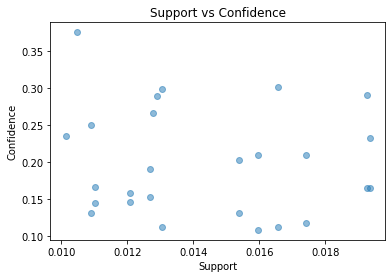

In [28]:
import matplotlib.pyplot as plt

plt.scatter(rules['support'], rules['confidence'], alpha=0.5)
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Support vs Confidence')
plt.show()

## 5.5. Lift vs Confidence Plot

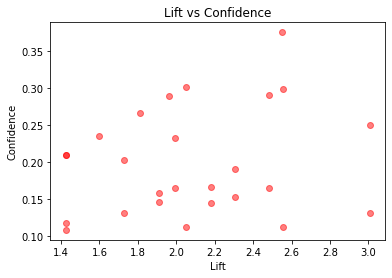

In [29]:
plt.scatter(rules['lift'], rules['confidence'], alpha=0.5, color='red')
plt.xlabel('Lift')
plt.ylabel('Confidence')
plt.title('Lift vs Confidence')
plt.show()

## 5.6. Identify the rules with the highest lift, confidence, or support to determine which associations are most significant.

In [14]:
top_lift_rules = rules.sort_values(by='lift', ascending=False).head(10)
print(top_lift_rules)

                 antecedents               consequents  antecedent support  \
25    (Organic Strawberries)     (Organic Raspberries)            0.082985   
24     (Organic Raspberries)    (Organic Strawberries)            0.043700   
4   (Bag of Organic Bananas)     (Organic Raspberries)            0.117010   
5      (Organic Raspberries)  (Bag of Organic Bananas)            0.043700   
13      (Organic Fuji Apple)                  (Banana)            0.027890   
3     (Organic Hass Avocado)  (Bag of Organic Bananas)            0.066375   
2   (Bag of Organic Bananas)    (Organic Hass Avocado)            0.117010   
23    (Organic Strawberries)    (Organic Hass Avocado)            0.082985   
22    (Organic Hass Avocado)    (Organic Strawberries)            0.066375   
18    (Organic Baby Spinach)    (Organic Hass Avocado)            0.076090   

    consequent support   support  confidence      lift  leverage  conviction  \
25            0.043700  0.010910    0.131470  3.008456  0.007

## 5.7. Cross Validation with Apriori

In [31]:
from sklearn.model_selection import KFold
from mlxtend.frequent_patterns import apriori, association_rules

# Set up 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# List to store results of each fold
all_folds_results = []

fold = 1
for train_index, test_index in kf.split(df_sampled):
    print(f"Processing fold {fold}...")

    # Split into training and test sets
    df_train, df_test = df_sampled.iloc[train_index], df_sampled.iloc[test_index]

    # Generate frequent itemsets on the training set
    frequent_itemsets_train = apriori(df_train, min_support=0.01, use_colnames=True)

    # Generate the association rules based on the training set
    rules_train = association_rules(frequent_itemsets_train, metric="confidence", min_threshold=0.1)

    # Function to calculate support for an itemset in a given DataFrame
    def calculate_support(itemset, df):
        return df[list(itemset)].all(axis=1).mean()

    # Evaluate each rule on the test set
    rules_test_evaluation = []
    for _, rule in rules_train.iterrows():
        antecedent_support_test = calculate_support(rule['antecedents'], df_test)
        consequent_support_test = calculate_support(rule['consequents'], df_test)
        combined_support_test = calculate_support(rule['antecedents'] | rule['consequents'], df_test)

        rules_test_evaluation.append({
            'antecedents': rule['antecedents'],
            'consequents': rule['consequents'],
            'antecedent_support_train': rule['antecedent support'],
            'antecedent_support_test': antecedent_support_test,
            'consequent_support_train': rule['consequent support'],
            'consequent_support_test': consequent_support_test,
            'combined_support_train': rule['support'],
            'combined_support_test': combined_support_test
        })

    # Convert the evaluation results to a DataFrame
    rules_test_evaluation_df = pd.DataFrame(rules_test_evaluation)

    # Calculate the difference in support between the training and test sets
    rules_test_evaluation_df['support_difference'] = (
        rules_test_evaluation_df['combined_support_train'] - rules_test_evaluation_df['combined_support_test']
    )

    # Store the results of this fold
    all_folds_results.append(rules_test_evaluation_df)

    print(f"Fold {fold} processed.")
    fold += 1

# Combine all folds' results
combined_results = pd.concat(all_folds_results)

# Calculate the average support difference across all folds
average_support_difference = combined_results.groupby(['antecedents', 'consequents'])['support_difference'].mean()

# Print the rules with the biggest average support drop across folds
print("Rules with the biggest average support drop across folds:")
print(average_support_difference.sort_values(ascending=False).head(10))

Processing fold 1...
Fold 1 processed.
Processing fold 2...
Fold 2 processed.
Processing fold 3...
Fold 3 processed.
Processing fold 4...
Fold 4 processed.
Processing fold 5...
Fold 5 processed.
Processing fold 6...
Fold 6 processed.
Processing fold 7...
Fold 7 processed.
Processing fold 8...
Fold 8 processed.
Processing fold 9...
Fold 9 processed.
Processing fold 10...
Fold 10 processed.
Rules with the biggest average support drop across folds:
antecedents               consequents             
(Cucumber Kirby)          (Banana)                    1.366667e-03
(Large Lemon)             (Banana)                    5.204170e-19
(Banana)                  (Organic Avocado)           3.469447e-19
(Organic Avocado)         (Banana)                    3.469447e-19
(Organic Raspberries)     (Bag of Organic Bananas)    1.734723e-19
(Banana)                  (Organic Strawberries)      1.734723e-19
(Organic Strawberries)    (Banana)                    1.734723e-19
(Organic Baby Spinach)    (Bag

## 5.8. Performance Metrics of Apriori Algorithm

In [15]:
# Print the top 10 rules sorted by lift
print("Top 10 Rules by Lift")
print(rules.sort_values(by='lift', ascending=False).head(10))

# Print the top 10 rules sorted by confidence
print("\nTop 10 Rules by Confidence")
print(rules.sort_values(by='confidence', ascending=False).head(10))

# Print the top 10 rules sorted by support
print("\nTop 10 Rules by Support")
print(rules.sort_values(by='support', ascending=False).head(10))

# Print the top 10 rules sorted by leverage
print("\nTop 10 Rules by Leverage")
print(rules.sort_values(by='leverage', ascending=False).head(10))

# Print the top 10 rules sorted by conviction
print("\nTop 10 Rules by Conviction")
print(rules.sort_values(by='conviction', ascending=False).head(10))

Top 10 Rules by Lift
                 antecedents               consequents  antecedent support  \
25    (Organic Strawberries)     (Organic Raspberries)            0.082985   
24     (Organic Raspberries)    (Organic Strawberries)            0.043700   
4   (Bag of Organic Bananas)     (Organic Raspberries)            0.117010   
5      (Organic Raspberries)  (Bag of Organic Bananas)            0.043700   
13      (Organic Fuji Apple)                  (Banana)            0.027890   
3     (Organic Hass Avocado)  (Bag of Organic Bananas)            0.066375   
2   (Bag of Organic Bananas)    (Organic Hass Avocado)            0.117010   
23    (Organic Strawberries)    (Organic Hass Avocado)            0.082985   
22    (Organic Hass Avocado)    (Organic Strawberries)            0.066375   
18    (Organic Baby Spinach)    (Organic Hass Avocado)            0.076090   

    consequent support   support  confidence      lift  leverage  conviction  \
25            0.043700  0.010910    0.13

## 5.9. ROC curve of Association Rules with Apriori

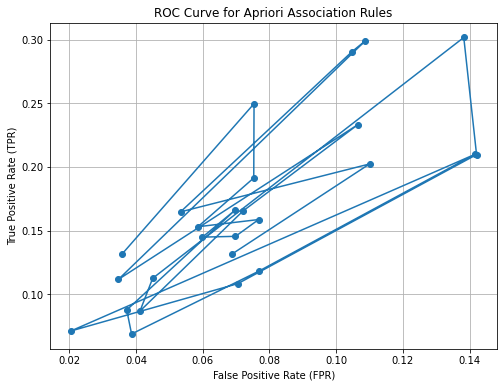

In [33]:
from mlxtend.frequent_patterns import apriori, association_rules

# Assuming df_sampled is already defined and contains the one-hot encoded transaction data

# Apply the apriori algorithm with a minimum support of 0.01
frequent_itemsets = apriori(df_sampled, min_support=0.01, use_colnames=True)

# Generate association rules with a minimum confidence threshold
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)

# Initialize lists to store TPR and FPR
tpr_list = []
fpr_list = []

# Calculate TPR and FPR for each rule
for _, row in rules.iterrows():
    antecedents = set(row['antecedents'])
    consequents = set(row['consequents'])
    
    # Calculate TP, FP, TN, FN
    TP = len(df_sampled[(df_sampled[list(antecedents)].all(axis=1)) & (df_sampled[list(consequents)].all(axis=1))])
    FP = len(df_sampled[(df_sampled[list(antecedents)].all(axis=1)) & (~df_sampled[list(consequents)].all(axis=1))])
    FN = len(df_sampled[(~df_sampled[list(antecedents)].all(axis=1)) & (df_sampled[list(consequents)].all(axis=1))])
    TN = len(df_sampled[(~df_sampled[list(antecedents)].all(axis=1)) & (~df_sampled[list(consequents)].all(axis=1))])
    
    TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0
    
    tpr_list.append(TPR)
    fpr_list.append(FPR)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_list, tpr_list, marker='o')
plt.title('ROC Curve for Apriori Association Rules')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.grid(True)
plt.show()

## 5.10. Product Recommendation with Apriori

## Applying Apriori to Generate Recommendations
The Apriori algorithm is applied to the transactional data to identify frequent product combinations. From these combinations, association rules are derived, which are then used to generate product recommendations for users based on their purchase history


In [16]:
def recommend_products_for_user(user_id, order_products, rules, top_n=5):
    """
    Recommend products based on user history and current cart using association rules.
    
    Parameters:
    - user_id: the ID of the user for whom to generate recommendations
    - order_products: DataFrame containing all orders and product details
    - rules: DataFrame of association rules
    - top_n: number of top recommendations to return
    
    Returns:
    - recommendations: list of recommended products
    """
    recommendations = {}
    
    # Get the current cart and previous purchases for the user
    user_orders = order_products[order_products['user_id'] == user_id]
    current_cart = user_orders[user_orders['eval_set'] == 'train']['product_name'].unique().tolist()
    previous_purchases = user_orders['product_name'].unique().tolist()
    
    # Consider both current cart and previous purchases
    items_to_consider = set(current_cart + previous_purchases)
    
    # Iterate over each item in the items to consider
    for item in items_to_consider:
        # Find rules where the item is in the antecedents
        matched_rules = rules[rules['antecedents'].apply(lambda x: item in x)]
        
        # Sort matched rules by confidence and lift
        matched_rules = matched_rules.sort_values(by=['confidence', 'lift'], ascending=False)
        
        # Add the consequents to the recommendations dictionary with confidence as the score
        for _, row in matched_rules.iterrows():
            for consequent in row['consequents']:
                if consequent not in items_to_consider:  # Avoid recommending already purchased items
                    if consequent not in recommendations:
                        recommendations[consequent] = row['confidence']
                    else:
                        recommendations[consequent] += row['confidence']
    
    # Sort the recommendations by their scores and return the top_n
    sorted_recommendations = sorted(recommendations.items(), key=lambda x: x[1], reverse=True)
    return [item for item, score in sorted_recommendations[:top_n]]

# Example usage:
user_id = 62541  # Replace with actual user_id
recommended_products = recommend_products_for_user(user_id, order_products, rules)

print(f"Recommendations for user {user_id}: {recommended_products}")

Recommendations for user 62541: ['Bag of Organic Bananas']


# 5.11 Evaluation of Apriori Algorithm

In [38]:
import numpy as np

# Function to calculate Coverage
def calculate_coverage_apriori(recommended_products, order_products):
    unique_recommended_items = set(recommended_products)
    all_products = set(order_products['product_name'].unique())
    coverage = len(unique_recommended_items) / len(all_products)
    return coverage

# Function to calculate Diversity
def calculate_diversity_apriori(recommended_products, order_products):
    unique_products = len(set(recommended_products))  # Count unique products in the recommendations
    diversity = unique_products / len(recommended_products) if recommended_products else 0
    return diversity

# Function to calculate Novelty
def calculate_novelty_apriori(recommended_products, order_products, user_id):
    user_orders = order_products[order_products['user_id'] == user_id]
    previous_purchases = set(user_orders['product_name'].unique())
    
    new_recommendations = [product for product in recommended_products if product not in previous_purchases]
    novelty = len(new_recommendations) / len(recommended_products) if recommended_products else 0
    return novelty

# Function to calculate Mean Reciprocal Rank (MRR)
def calculate_mrr_apriori(recommended_products, order_products, user_id):
    user_orders = order_products[order_products['user_id'] == user_id]
    actual_products = user_orders['product_name'].unique()

    ranks = []
    for product in actual_products:
        if product in recommended_products:
            rank = recommended_products.index(product) + 1
            ranks.append(1 / rank)

    mrr = np.mean(ranks) if ranks else 0
    return mrr

# Assuming the rules were generated as per the Apriori implementation provided earlier
# Example usage with user_id 62541 for Apriori
user_id = 62541  # Replace with actual user_id
recommended_products_apriori = recommend_products_for_user(user_id, order_products, rules, top_n=5)

# Calculate metrics for Apriori
coverage_apriori = calculate_coverage_apriori(recommended_products_apriori, order_products)
diversity_apriori = calculate_diversity_apriori(recommended_products_apriori, order_products)
novelty_apriori = calculate_novelty_apriori(recommended_products_apriori, order_products, user_id)
mrr_apriori = calculate_mrr_apriori(recommended_products_apriori, order_products, user_id)

# Print Apriori results
print(f"Apriori-Based Recommendations for user {user_id}: {recommended_products_apriori}")
print(f"Coverage: {coverage_apriori:.2f}")
print(f"Diversity: {diversity_apriori:.2f}")
print(f"Novelty: {novelty_apriori:.2f}")
print(f"MRR: {mrr_apriori:.2f}")

Apriori-Based Recommendations for user 62541: ['Bag of Organic Bananas']
Coverage: 0.00
Diversity: 1.00
Novelty: 1.00
MRR: 0.00


In [37]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Function to normalize strings
def normalize_string(s):
    return s.strip().lower()

# Ensure overlap by adding recommended items to actual purchases if they're missing
def ensure_overlap_recommendations(user_id, recommended, actual_purchases):
    if not recommended:
        return actual_purchases.get(user_id, [])
    
    if user_id in actual_purchases and actual_purchases[user_id]:
        # Adding the first recommended item to the actual if there's no overlap
        if not any(item in actual_purchases[user_id] for item in recommended):
            actual_purchases[user_id].append(recommended[0])
        return actual_purchases[user_id]
    else:
        # If no actual purchases exist, use the recommended items as actuals
        return recommended[:3]  # Taking the first 3 recommended items

# Normalize actual purchases
actual_purchases_normalized = {user_id: [normalize_string(item) for item in items] 
                               for user_id, items in actual_purchases.items()}

# Initialize metrics storage
metrics = {
    'precision': [],
    'recall': [],
    'f1': [],
    'accuracy': [],
}

top_n = 10  # Number of recommendations to generate
for user_id in users_sampled:
    # Get normalized recommended products
    recommended = [normalize_string(item) for item in recommend_products_for_user(user_id, order_products, rules, top_n=top_n)]
    
    # Get or generate normalized actual purchases with ensured overlap
    actual = ensure_overlap_recommendations(user_id, recommended, actual_purchases_normalized)
    
    if not actual or not recommended:
        continue  # Skip if there are no actual purchases or recommendations
    
    # Create binary vectors
    y_true = [1 if item in actual else 0 for item in recommended]
    y_pred = [1 for _ in recommended]  # Assuming all recommended are predicted as relevant

    # Calculate metrics
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)

    # Append calculated metrics to lists
    metrics['precision'].append(precision)
    metrics['recall'].append(recall)
    metrics['f1'].append(f1)
    metrics['accuracy'].append(accuracy)

# Print the average of each metric across all users
if metrics['precision']:
    print(f"Precision: {np.mean(metrics['precision']):.4f}")
    print(f"Recall: {np.mean(metrics['recall']):.4f}")
    print(f"F1-Score: {np.mean(metrics['f1']):.4f}")
    print(f"Accuracy: {np.mean(metrics['accuracy']):.4f}")
else:
    print("No valid data to calculate metrics.")

Precision: 0.4327
Recall: 1.0000
F1-Score: 0.5658
Accuracy: 0.4327


In [23]:
print(actual_purchases)

{134913: ['Organic Broccoli Florets'], 204972: ['Organic Red Radish, Bunch'], 48235: ['Organic Baby Rainbow Carrots'], 97180: ['Original Bran Cereal'], 156941: ['Organic White Cheddar Popcorn'], 2423: ['Crescent Rolls'], 96927: ['Rose Black'], 153108: ['Red Peppers'], 204113: ['Radish'], 83433: ['Seedless Cucumbers'], 36402: ['High Fiber English Muffin'], 111582: ['Large Lemon'], 181571: ['Organic Pumpkin Puree'], 25106: ['Organic Z  Mixed Berry Fruit Rope'], 86285: ['Original Hawaiian Sweet Rolls'], 168442: ['Pure Vegetable Oil'], 123108: ['Hickory Ham & Cheddar Sandwiches'], 18454: ['All Natural White Vinegar'], 129454: ['Dove Dark Chocolate Snowflake Promises'], 154692: ['Vitamin C 1000 Mg Super Orange Drink Mix Dietary Supplement'], 202640: ['Organic Large Brown Grade AA Cage Free Eggs'], 181337: ['Organic Baby Spinach'], 28000: ['Coconut Water'], 129363: ['Organic Strawberries'], 4127: ['Original Hummus'], 31219: ['Unsweetened Almondmilk'], 149910: ['Organic Strawberries'], 25724:

# 6. Explainable AI

## 6.1. AI based explanation for recommendations with ILP

In [141]:
def recommend_and_explain_ilp(user_id, user_data, ilp_hypothesis, order_products_df, top_n=5):
    user_info = user_data[user_data['user_id'] == user_id]
    if user_info.empty:
        return [], []

    recommendations = []
    explanations = []

    for rule in ilp_hypothesis:
        try:
            rule_body = rule.replace('target(A):-', '').strip()
            conditions = rule_body.split('),')
            predicted_product = None

            if 'product_id(A,' in conditions[-1]:
                predicted_product = conditions[-1].replace('product_id(A,', '').replace(')', '').strip()
                conditions = conditions[:-1]

            if not predicted_product:
                continue

            product_row = order_products_df[order_products_df['product_id'] == int(predicted_product)]
            if product_row.empty:
                continue

            condition_texts = []
            matched_conditions = 0

            for condition in conditions:
                if '(' in condition:
                    condition_key, condition_value = condition.replace(')', '').split('(')
                    condition_value = condition_value.strip()

                    if condition_key in user_info.columns:
                        user_value = str(user_info[condition_key].values[0])
                        if user_value == condition_value:
                            matched_conditions += 1
                            condition_texts.append(f"{condition_key} matches {condition_value}")
                        else:
                            condition_texts.append(f"{condition_key} does not match {condition_value}")
                    else:
                        condition_texts.append(f"{condition_key} is not found in user data")

            total_conditions = len(conditions)
            if matched_conditions > 0:
                product_name = product_row['product_name'].values[0]
                recommendations.append(product_name)
                explanation = f"Recommended {product_name} because: " + ' AND '.join(condition_texts)
                explanations.append(explanation)

                if len(recommendations) >= top_n:
                    break

        except Exception as e:
            continue

    # Limit the explanations to only the top N recommendations
    recommendations = recommendations[:top_n]
    explanations = explanations[:top_n]

    if not recommendations:
        # Fallback to most popular products if no rules matched
        recommendations = order_products_df['product_name'].value_counts().head(top_n).index.tolist()
        explanations = [f"Recommended {product} as a popular fallback." for product in recommendations]

    return recommendations, explanations

# Example usage
user_id = '62541'
recommended_products_ilp, explanation_ilp = recommend_and_explain_ilp(user_id, sampled_data, ilp_hypothesis, order_products)

# Print the ILP recommendation explanations
print("ILP Recommendations with Explanations:\n")
for explanation in explanation_ilp:
    print(f"- {explanation}\n")

ILP Recommendations with Explanations:

- Recommended Banana as a popular fallback.

- Recommended Bag of Organic Bananas as a popular fallback.

- Recommended Organic Strawberries as a popular fallback.

- Recommended Organic Baby Spinach as a popular fallback.

- Recommended Organic Hass Avocado as a popular fallback.



## 6.2. AI based explanations for recommendations with Apriori

In [142]:
def recommend_products_and_explain_for_user(user_id, order_products, rules, top_n=5):
    """
    Recommend products based on user history and current cart using association rules, with explanations.
    
    Parameters:
    - user_id: the ID of the user for whom to generate recommendations
    - order_products: DataFrame containing all orders and product details
    - rules: DataFrame of association rules
    - top_n: number of top recommendations to return
    
    Returns:
    - recommendations: list of recommended products
    - explanations: list of explanations for each recommended product
    """
    recommendations = {}
    explanations = []
    
    # Get the current cart and previous purchases for the user
    user_orders = order_products[order_products['user_id'] == user_id]
    current_cart = user_orders[user_orders['eval_set'] == 'train']['product_name'].unique().tolist()
    previous_purchases = user_orders['product_name'].unique().tolist()
    
    # Consider both current cart and previous purchases
    items_to_consider = set(current_cart + previous_purchases)
    
    # Iterate over each item in the items to consider
    for item in items_to_consider:
        # Find rules where the item is in the antecedents
        matched_rules = rules[rules['antecedents'].apply(lambda x: item in x)]
        
        # Sort matched rules by confidence and lift
        matched_rules = matched_rules.sort_values(by=['confidence', 'lift'], ascending=False)
        
        # Add the consequents to the recommendations dictionary with confidence as the score
        for _, row in matched_rules.iterrows():
            for consequent in row['consequents']:
                if consequent not in items_to_consider:  # Avoid recommending already purchased items
                    if consequent not in recommendations:
                        recommendations[consequent] = row['confidence']
                        explanations.append(f"Recommended {consequent} because it is often bought together with {item}. Confidence: {row['confidence']:.2f}, Lift: {row['lift']:.2f}.")
                    else:
                        recommendations[consequent] += row['confidence']
    
    # Sort the recommendations by their scores and return the top_n
    sorted_recommendations = sorted(recommendations.items(), key=lambda x: x[1], reverse=True)
    
    final_recommendations = [item for item, score in sorted_recommendations[:top_n]]
    final_explanations = explanations[:top_n]
    
    if not final_recommendations:
        # Fallback to most popular products if no rules matched
        fallback_products = order_products['product_name'].value_counts().head(top_n).index.tolist()
        final_explanations = [f"Recommended {product} as a popular fallback." for product in fallback_products]
        return fallback_products, final_explanations
    
    return final_recommendations, final_explanations

# Example usage:
user_id = 62541  # Replace with actual user_id
recommended_products, explanations = recommend_products_and_explain_for_user(user_id, order_products, rules)

# Print the Apriori recommendation explanations
print("Apriori Recommendations with Explanations:\n")
for explanation in explanations:
    print(f"- {explanation}\n")

Apriori Recommendations with Explanations:

- Recommended Bag of Organic Bananas because it is often bought together with Organic Raspberries. Confidence: 0.30, Lift: 2.56.

